In [127]:
!pip install -U kaleido

In [128]:
import pandas as pd
import plotly.express as px

In [129]:
try:
  df = pd.read_excel('/content/2022(3).xlsx', sheet_name = 'category')
except Exception as e:
  print(f'Ошибка: {e}')

 # Распределения по кол-ву элементов в заявке

In [130]:
df.head(10)

,ID счета,state,Дата счета,Регион,ID плательщика,Название плательщика,ID поставщика,Название поставщика,ID заявки,ID позиции заявки,...,Категория,ID позиции счета,Название в счете,Кол-во в счете,ЕИ позиции счета,Цена за ед,НДС включен?,Процент НДС,Сумма,Комплектность
0,260823883,PAID,2022-05-06 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",127773.0,"ООО ""ТПП ""ТЕХНОДЕКОР""",12864133,12897510,...,Лакокрасочные материалы,22254978,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...,2.0,шт,370.000,True,0.2,740.00,NaN
1,260823883,PAID,2022-05-06 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",127773.0,"ООО ""ТПП ""ТЕХНОДЕКОР""",12864133,12897510,...,Лакокрасочные материалы,22254977,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...,1.0,шт,1088.500,True,0.2,1088.50,NaN
2,260823946,ACCEPTED_BY_ACCEPTORS,2022-05-06 03:00:00,г. Санкт-Петербург,56724.0,"ООО ""СЭТЛ СТРОЙ""",54849.0,"АО ""БЕАТОН""",12895635,13019010,...,"Асфальт, тротуарная плитка",22254979,"Пористая крупнозернистая марка 2 (гранит, БНД)...",240.0,т,3720.000,True,0.2,892800.00,NaN
3,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978030,...,СИЗ,22254982,ПЕРЧАТКИ х/б двойной облив,300.0,пара,27.400,True,0.2,8220.00,NaN
4,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978034,...,Инструмент ручной,22254985,"ФОНАРЬ налобный, светодиодный, аккумуляторный",10.0,шт,379.665,True,0.2,3796.65,NaN
5,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978028,...,Кабели с медной жилой,22254980,ВИЛКА 2P+E 1*16A каучук IP44,25.0,шт,63.800,True,0.2,1595.00,NaN
6,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978033,...,СИЗ,22254984,МАСКА СВАРЩИКА FUBAG OPTIMA Visor Silver (4-8/...,5.0,шт,5875.000,True,0.2,29375.00,NaN
7,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978029,...,СИЗ,22254981,КРАГИ спилковые,50.0,пара,240.000,True,0.2,12000.00,NaN
8,260823961,NEW,2022-05-04 03:00:00,г. Москва,104925.0,"ООО ""СИТИСТРОЙ""",87156.0,"ООО ""ФИРМА ""ОСНОВНОЙ ПОСТАВЩИК""",12884378,12978031,...,СИЗ,22254983,СТЕКЛО покровное 121*69 мм,50.0,шт,14.420,True,0.2,721.00,NaN
9,260823991,NEW,2022-05-06 03:00:00,г. Санкт-Петербург,50334.0,"ООО ""СТРОЙ ПРОГРЕСС""",118503.0,"ООО ""СКС""",12889037,12993401,...,Санфаянс,22254989,"Тумба под раковину Next 60, подвесная, 2 ящика...",55.0,шт,6500.000,True,0.2,357500.00,NaN


In [131]:
df.iloc[0]

,0
ID счета,260823883
state,PAID
Дата счета,2022-05-06 03:00:00
Регион,Чувашская Республика
ID плательщика,384042.0
Название плательщика,"ООО ""СК-ЛЕРОН"""
ID поставщика,127773.0
Название поставщика,"ООО ""ТПП ""ТЕХНОДЕКОР"""
ID заявки,12864133
ID позиции заявки,12897510


In [132]:
df.iloc[1]

,1
ID счета,260823883
state,PAID
Дата счета,2022-05-06 03:00:00
Регион,Чувашская Республика
ID плательщика,384042.0
Название плательщика,"ООО ""СК-ЛЕРОН"""
ID поставщика,127773.0
Название поставщика,"ООО ""ТПП ""ТЕХНОДЕКОР"""
ID заявки,12864133
ID позиции заявки,12897510


In [133]:
df.iloc[2]['Название в заявке']

'Смесь асфальтобетонная крупнозернистая пористая марка II'

In [134]:
df.iloc[2]['Название в счете']

'Пористая крупнозернистая марка 2 (гранит, БНД) - а/б смесь'

In [135]:
# не рассматриваем примеры с комплектностью
df = df[df['Комплектность'].isna()].drop(['Комплектность'], axis = 1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 468587 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID счета              468587 non-null  int64  
 1   state                 468587 non-null  object 
 2   Дата счета            468587 non-null  object 
 3   Регион                468585 non-null  object 
 4   ID плательщика        468586 non-null  float64
 5   Название плательщика  468576 non-null  object 
 6   ID поставщика         466423 non-null  float64
 7   Название поставщика   463985 non-null  object 
 8   ID заявки             468587 non-null  int64  
 9   ID позиции заявки     468587 non-null  int64  
 10  Название в заявке     468585 non-null  object 
 11  Кол-во в заявке       468587 non-null  float64
 12  ЕИ позиции заявки     468587 non-null  object 
 13  Категория             466590 non-null  object 
 14  ID позиции счета      468587 non-null  int64  
 15  Назва

In [136]:
df[['Название в заявке', 'Название в счете']].head(10)

,Название в заявке,Название в счете
0,Грунт-эмаль 3 в.1 по ржавчине,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...
1,Грунт-эмаль 3 в.1 по ржавчине,Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУ...
2,Смесь асфальтобетонная крупнозернистая пориста...,"Пористая крупнозернистая марка 2 (гранит, БНД)..."
3,Перчатки с двойным латексным покрытием,ПЕРЧАТКИ х/б двойной облив
4,Налобный фонарь ЯРКИЙ ЛУЧ LH-180 ACCU,"ФОНАРЬ налобный, светодиодный, аккумуляторный"
5,Кабель ПВС 2*1.5 ВМЕСТО КАБЕЛЯ приобрести \t\n...,ВИЛКА 2P+E 1*16A каучук IP44
6,"Маска сварщика хамелеон ,РАЗМЕР СВЕТОФИЛЬТРА: ...",МАСКА СВАРЩИКА FUBAG OPTIMA Visor Silver (4-8/...
7,Краги для сварщика (красные),КРАГИ спилковые
8,"Стекло защитное прозрачное, РАЗМЕР: 120 х 70 мм",СТЕКЛО покровное 121*69 мм
9,#_Тумба под умывальник,"Тумба под раковину Next 60, подвесная, 2 ящика..."


In [137]:
dict_appl = {}
for i in df['ID заявки'].unique():
  ff = df[df['ID заявки'] == i]
  dict_appl[i] = len(ff['ID позиции заявки'].unique())

In [138]:
n_products_new = pd.DataFrame(dict_appl.values())
n_products = n_products_new.copy()
n_products

,0
0,27
1,1
2,6
3,2
4,1
...,...
35550,1
35551,4
35552,1
35553,2


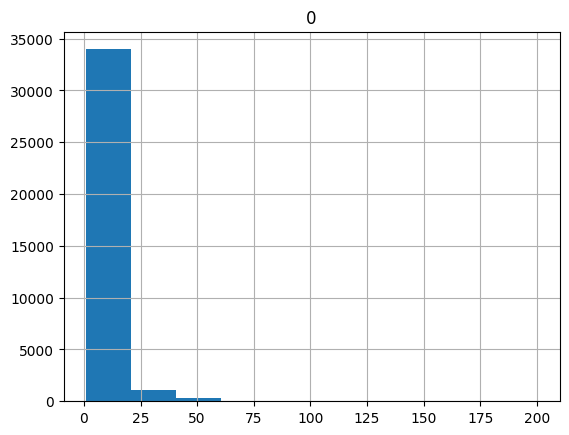

In [139]:
# n_products = df[['ID заявки', 'ID позиции заявки']].groupby('ID заявки').count()
n_products.hist();

In [140]:
n_products.describe()

,0
count,35555.000000
mean,5.100211
std,9.497198
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,200.000000


In [141]:
fig = px.box(n_products)
fig.show()

In [142]:
n_products = n_products.rename(columns={0: 'Количество товаров в заявке'})

In [143]:
fig = px.histogram(n_products,
                   x='Количество товаров в заявке',
                   title='Распределение количества товаров в заявке',
                   width=1400,
                   height=800)
fig.update_layout(
    title={
        'text': 'Распределение количества товаров в заявке',
        'x': 0.5,
        'xanchor': 'center',
        'font': {
            'size': 20,
            'family': 'Arial Black'
        }
    },
    yaxis=dict(
        dtick=500,
        title='Количество заявок'
    ),
    xaxis=dict(
        dtick=5,
        title='Количество товаров'
    )
)
fig.show()

In [144]:
# оставляем данные, где количество не превышает верхней границы
n_products_down = n_products[n_products['Количество товаров в заявке'] <= 11]
n_products_down.describe()

,Количество товаров в заявке
count,31850.000000
mean,2.766531
std,2.508974
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,11.000000


In [145]:
fig = px.histogram(n_products_down,
                   x='Количество товаров в заявке',
                   title='Распределение количества товаров в заявке',
                   width=1400,
                   height=800)
fig.update_layout(
    title={
        'text': 'Распределение количества товаров в заявке',
        'x': 0.5,
        'xanchor': 'center',
        'font': {
            'size': 20,
            'family': 'Arial Black'
        }
    },
    yaxis=dict(
        dtick=500,
        title='Количество заявок'
    ),
    xaxis=dict(
        dtick=1,
        title='Количество товаров'
    )
)
fig.show()

In [146]:
n_products_up = n_products[n_products['Количество товаров в заявке'] > 11]

fig = px.histogram(n_products_up,
                   x='Количество товаров в заявке',
                   title='Распределение количества товаров в заявке',
                   width=1400,
                   height=800)
fig.update_layout(
    title={
        'text': 'Распределение количества товаров в заявке',
        'x': 0.5,
        'xanchor': 'center',
        'font': {
            'size': 20,
            'family': 'Arial Black'
        }
    },
    yaxis=dict(
        dtick=50,
        title='Количество заявок'
    ),
    xaxis=dict(
        dtick=5,
        title='Количество товаров'
    )
)
fig.show()

In [147]:
n_products_mid = n_products[(n_products['Количество товаров в заявке'] > 1) & (n_products['Количество товаров в заявке'] <= 11)]
n_products_mid.describe()

,Количество товаров в заявке
count,16620.000000
mean,4.385319
std,2.565801
min,2.000000
25%,2.000000
50%,3.000000
75%,6.000000
max,11.000000


In [148]:
fig = px.histogram(n_products_mid,
                   x='Количество товаров в заявке',
                   title='Распределение количества товаров в заявке',
                   width=1400,
                   height=800)
fig.update_layout(
    title={
        'text': 'Распределение количества товаров в заявке',
        'x': 0.5,
        'xanchor': 'center',
        'font': {
            'size': 20,
            'family': 'Arial Black'
        }
    },
    yaxis=dict(
        dtick=500,
        title='Количество заявок'
    ),
    xaxis=dict(
        dtick=1,
        title='Количество товаров'
    )
)
fig.show()

# Формировавние тестовой выборки

In [149]:
arr_ones_id = []

for id in dict_appl:
  if dict_appl[id] == 1:
    arr_ones_id.append(id)

print(f'Количество заявок с 1 товаром: {len(arr_ones_id)}')

Количество заявок с 1 товаром: 15230


In [150]:
df_new = df[~df['ID заявки'].isin(arr_ones_id)]
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 436818 entries, 0 to 499999
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID счета              436818 non-null  int64  
 1   state                 436818 non-null  object 
 2   Дата счета            436818 non-null  object 
 3   Регион                436816 non-null  object 
 4   ID плательщика        436817 non-null  float64
 5   Название плательщика  436811 non-null  object 
 6   ID поставщика         434782 non-null  float64
 7   Название поставщика   432738 non-null  object 
 8   ID заявки             436818 non-null  int64  
 9   ID позиции заявки     436818 non-null  int64  
 10  Название в заявке     436818 non-null  object 
 11  Кол-во в заявке       436818 non-null  float64
 12  ЕИ позиции заявки     436818 non-null  object 
 13  Категория             435008 non-null  object 
 14  ID позиции счета      436818 non-null  int64  
 15  Назва

In [151]:
value_counts = df['Категория'].value_counts()
pd.set_option('display.max_rows', None)
print(value_counts)
pd.reset_option('display.max_rows')

Категория
Метизы                                                                  39581
Воздуховоды и фасонные изделия                                          39153
Инструмент ручной                                                       24639
Кабели с медной жилой                                                   20960
Расходные материалы для инструмента (буры, биты, диски)                 19017
Запорно-регулирующая трубопроводная арматура                            17922
Арматура                                                                17100
Детали трубопровода                                                     11187
СИЗ                                                                      8614
Металлические трубы (черные)                                             8500
Электроустановочная продукция                                            8467
Полипропиленовые трубы (ППР)                                             7689
Противопожарные клапаны                               

In [152]:
# оставим только те данные, где была произведена оплата (state == PAID)
df_new = df_new[df_new.state == 'PAID']
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59249 entries, 0 to 499925
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID счета              59249 non-null  int64  
 1   state                 59249 non-null  object 
 2   Дата счета            59249 non-null  object 
 3   Регион                59249 non-null  object 
 4   ID плательщика        59249 non-null  float64
 5   Название плательщика  59243 non-null  object 
 6   ID поставщика         59243 non-null  float64
 7   Название поставщика   57654 non-null  object 
 8   ID заявки             59249 non-null  int64  
 9   ID позиции заявки     59249 non-null  int64  
 10  Название в заявке     59249 non-null  object 
 11  Кол-во в заявке       59249 non-null  float64
 12  ЕИ позиции заявки     59249 non-null  object 
 13  Категория             58141 non-null  object 
 14  ID позиции счета      59249 non-null  int64  
 15  Название в счете      5

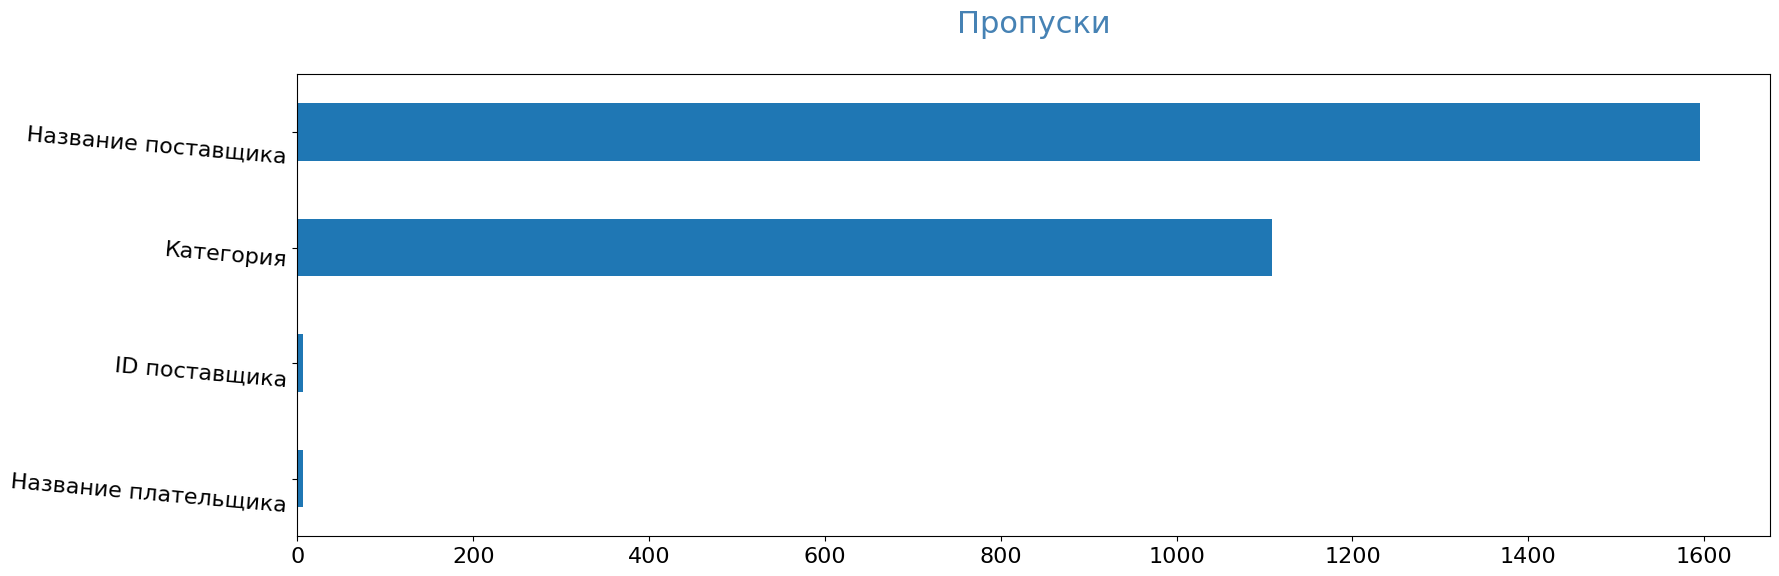

In [153]:
def pass_value_barh(df):
  """
  Функция для наглядного представления пропусков в данных

  input: DataFrame - df
  """
  try:
     (
         (df.isna().sum())
          .to_frame()
          .rename(columns = {0:'space'})
          .query('space > 0')
          .sort_values(by = 'space', ascending = True)
          .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
          .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')
          );
  except:
    print('пропусков не осталось ')

pass_value_barh(df_new)

In [154]:
df_new[df_new['Название поставщика'].isna()]

,ID счета,state,Дата счета,Регион,ID плательщика,Название плательщика,ID поставщика,Название поставщика,ID заявки,ID позиции заявки,...,ЕИ позиции заявки,Категория,ID позиции счета,Название в счете,Кол-во в счете,ЕИ позиции счета,Цена за ед,НДС включен?,Процент НДС,Сумма
1402,260833884,PAID,2022-05-06 14:14:04.012,Республика Коми,114554.0,"ООО ""ЭНЕРГОАКТИВ""",105138.0,NaN,12798046,12634371,...,шт,Системы контроля и управления доступом,22256783,Кнопка С2000_КТ 5,1.0,шт,0.01,True,0.2,0.01
7174,260871597,PAID,2022-05-06 16:23:52.132,Республика Коми,124583.0,"ООО ""ГАРАНТСНАБ""",252484.0,NaN,12836226,12785511,...,час,Аренда спецтехники,22263996,Экскаватор на гусеничном ходу с оборудованием ...,50.0,час,2300.00,True,0.2,115000.00
8559,260884951,PAID,2022-05-06 17:08:42.545,Вологодская область,132162.0,Вологодская транспортная компания,126177.0,NaN,12894388,13013220,...,шт,Запасные части для автомашин,22265557,труба подачи масла к турбине ISF 2.8 1 1 1,1.0,шт,1050.00,True,0.2,1050.00
8560,260884951,PAID,2022-05-06 17:08:42.545,Вологодская область,132162.0,Вологодская транспортная компания,126177.0,NaN,12894388,13013221,...,шт,Запасные части для автомашин,22265558,трубка слива масла с турбины Cummins 2.8 1 1 1,1.0,шт,1250.00,True,0.2,1250.00
8561,260884951,PAID,2022-05-06 17:08:42.545,Вологодская область,132162.0,Вологодская транспортная компания,126177.0,NaN,12894388,13013219,...,шт,Запасные части для автомашин,22265556,коллектор выпускной Cummins 2.8 Евро-4 1 1 1,1.0,шт,9000.00,True,0.2,9000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497734,270880371,PAID,2022-06-02 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",433437.0,NaN,12980712,13365790,...,шт,Трубы кабеленесущие,22874900,Крепеж-клипса для труб ПВХ диаметр 16 серый (P...,200.0,шт,1.94,False,0.0,388.00
497735,270880371,PAID,2022-06-02 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",433437.0,NaN,12980712,13365791,...,м,Кабели с медной жилой,22874901,"КСПВ 4x0,5 Кабель",50.0,м,18.70,False,0.0,935.00
497736,270880371,PAID,2022-06-02 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",433437.0,NaN,12980712,13365788,...,шт,Охранно-пожарная сигнализация,22874898,Маяк-12-КП комбинированный оповещатель,1.0,шт,509.00,False,0.0,509.00
497737,270880371,PAID,2022-06-02 03:00:00,Чувашская Республика,384042.0,"ООО ""СК-ЛЕРОН""",433437.0,NaN,12980712,13365787,...,шт,Охранно-пожарная сигнализация,22874897,И ПР 513-10 Извещатель пожарный ручной,1.0,шт,341.00,False,0.0,341.00


In [155]:
df_new = df_new.dropna()

In [156]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56631 entries, 0 to 499925
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID счета              56631 non-null  int64  
 1   state                 56631 non-null  object 
 2   Дата счета            56631 non-null  object 
 3   Регион                56631 non-null  object 
 4   ID плательщика        56631 non-null  float64
 5   Название плательщика  56631 non-null  object 
 6   ID поставщика         56631 non-null  float64
 7   Название поставщика   56631 non-null  object 
 8   ID заявки             56631 non-null  int64  
 9   ID позиции заявки     56631 non-null  int64  
 10  Название в заявке     56631 non-null  object 
 11  Кол-во в заявке       56631 non-null  float64
 12  ЕИ позиции заявки     56631 non-null  object 
 13  Категория             56631 non-null  object 
 14  ID позиции счета      56631 non-null  int64  
 15  Название в счете      5

В финальной выборке отсутствуют данные о комплектности, так как мы их пока что не рассматриваем, оставлены данные, где в заяке больше одного товара и заявка была оплачена,  а значит имеет корректные названия товаров в заявке и счете

In [157]:
df_new.duplicated().sum()

0

In [161]:
# сохранение в excel формате
df_new.to_excel('df_x.xlsx', index=False)

In [162]:
# сохранение в csv формате
df_new.to_csv('df_c.csv', index=False)

In [160]:
for i in range(10):
    print(f"Название в заявке: {df_new.iloc[i]['Название в заявке']} / Название в счете: {df_new.iloc[i]['Название в счете']}")


Название в заявке: Грунт-эмаль 3 в.1 по ржавчине / Название в счете: Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУМАТОВАЯ быстросохнущая (0,9 кг)
Название в заявке: Грунт-эмаль 3 в.1 по ржавчине / Название в счете: Грунт-эмаль З-в-1 Ferumprotect-201 Желтая ПОЛУМАТОВАЯ быстросохнущая (2,7 кг)
Название в заявке: Арматура ⌀ 6 А240 / Название в счете: Арматура AI 6 ст.З ГОСТ 5781-82 6м
Название в заявке: Арматура ⌀ 8 А500С / Название в счете: Арматура А500С 8 ГОСТ 34028-2016 11,7м
Название в заявке: Арматура ⌀ 12 А500С / Название в счете: Арматура А500С 12 ГОСТ 34028-2016 11,7м
Название в заявке: Арматура ⌀ 10 А500С / Название в счете: Арматура А500С 10 ГОСТ 34028-2016 11,7м
Название в заявке: Бита PH 2/125 / Название в счете: БИТА PH-2 127мм
Название в заявке: Мешок для строит.мусора полипропиленовый тканный 55х95 (зеленый) (уп. 100 шт) / Название в счете: МЕШОК для мусора п/п 90 х 50 см (зеленый)
Название в заявке: Инд. металлическая дверь 2250*810 Л / Название в счете: Изготовление и м